In [84]:
from __future__ import absolute_import, division, print_function
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow import keras
import skimage
from skimage import data
from skimage.transform import resize
from PIL import Image
import matplotlib.image as mpimg
import numpy as np
import glob
from sympy.combinatorics.named_groups import *

tf.logging.set_verbosity(tf.logging.INFO)

In [85]:
directory = '../data/mnist_png/'

In [86]:
G = DihedralGroup(4)
#G = CyclicGroup(4)

G = list(G.generate_dimino())

i_f_g = {}
g_f_i = {}
for i in range(len(G)):
    g_f_i[i] = G[i]
    i_f_g[G[i]] = i

In [87]:
i_f_g

{Permutation(3): 0,
 Permutation(0, 1, 2, 3): 1,
 Permutation(0, 2)(1, 3): 2,
 Permutation(0, 3, 2, 1): 3,
 Permutation(0, 3)(1, 2): 4,
 Permutation(1, 3): 5,
 Permutation(0, 1)(2, 3): 6,
 Permutation(3)(0, 2): 7}

In [88]:
g_f_i

{0: Permutation(3),
 1: Permutation(0, 1, 2, 3),
 2: Permutation(0, 2)(1, 3),
 3: Permutation(0, 3, 2, 1),
 4: Permutation(0, 3)(1, 2),
 5: Permutation(1, 3),
 6: Permutation(0, 1)(2, 3),
 7: Permutation(3)(0, 2)}

In [89]:
# let ei be the obvious element in R^10
# let F_hat be the perfect network after trainning.
# let xi in X be an image that represents the handwritting of number i.
# then we want (define) [F_hat(xi)](gj) = ei if j = 0; 0 else. Here, g0 is the identity element (not required tho)
# note F(xi) = p[F_hat(xi)] = [F_hat(xi)](g0) = ei
# now we calculate [F_hat(g xi)]
# [F_hat(g xi)](gj) = [g F_hat(xi)](gj) = [F_hat(xi)](g^(-1) gj)
# by the definition, and let g = gk, then
# [F_hat(gk xi)](gj) = ei if gk = gj, i.e. k =j; 0 else. 
# Note that we identify Z^{x G} with G x G x ... x G via
# s \mapsto s(g0), s(g1), ..., s(g(n-1)), where n = |G|
# hence, F_hat(gk xi) is mapped to (0,...,ei,...,0), where ei is at the location k

In [90]:
def str_to_vect(label, angle):
    #label denotes the number 0-9
    #angle is in this case, clockwise. In general, the these two are related to how we encode the operations
    i = int(label)
    k = int(angle)
    ei = []
    for j in range(10):
        if j == i:
            ei.append(1)
        else:
            ei.append(0)
    zero = [0]*10
    vec = []
    for j in range(len(G)):
        if j == k:
            vec.append(ei)
        else:
            vec.append(zero)
    res = []
    for a in vec:
        for b in a:
            res.append(b)
    return res

In [91]:
print (str_to_vect(0,5))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [92]:
#loaddata
def loaddata(s):
    filelist = glob.glob(directory + s + '/*.png')
    y_temp = []
    x_temp = []
    print (directory + s + '/*.png')
    for fname in filelist:
        short_name = fname.split('/')[-1]
        label, angle, name = short_name.split('_')
        img = mpimg.imread(fname)
        x_temp.append(img)
        vector = str_to_vect(label, angle)
        y_temp.append(vector)

    x = np.asarray(x_temp)
    y = np.asarray(y_temp)
    print (s + ' import done. the shapes of x and y are:', x.shape, y.shape)
    return x, y


In [93]:
train_x, train_y = loaddata('trainingx')

../data/mnist_png/trainingx/*.png
trainingx import done. the shapes of x and y are: (60000, 28, 28) (60000, 80)


In [94]:
test_x, test_y = loaddata('testingx')

../data/mnist_png/testingx/*.png
testingx import done. the shapes of x and y are: (10000, 28, 28) (10000, 80)


In [95]:
samples_x, samples_y = loaddata('samplesx')
samples_x = samples_x/np.float32(255)

../data/mnist_png/samplesx/*.png
samplesx import done. the shapes of x and y are: (8, 28, 28) (8, 80)


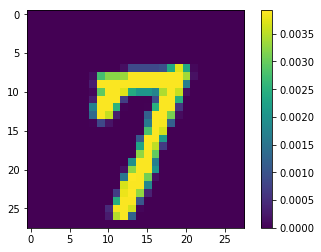

In [96]:
plt.figure()
plt.imshow(samples_x[4])
plt.colorbar()
plt.grid(False)
plt.show()

In [97]:
# representation of group G. 
# for each group element, we associate it with a transformation.
# the following is only for the rotation by 90 or reflection along x, y
operations = {}

operations[g_f_i[0]] = (lambda x: tf.image.rot90(x, k =0))
operations[g_f_i[1]] = (lambda x: tf.image.rot90(x, k =3))
operations[g_f_i[2]] = (lambda x: tf.image.rot90(x, k =2))
operations[g_f_i[3]] = (lambda x: tf.image.rot90(x, k =1))

if len(G) > 4:
    operations[g_f_i[4]] = (lambda x: tf.image.flip_up_down(x))
    operations[g_f_i[5]] = (lambda x: tf.image.flip_left_right(tf.image.rot90(x, k = 1)))
    operations[g_f_i[6]] = (lambda x: tf.image.flip_left_right(x))
    operations[g_f_i[7]] = (lambda x: tf.image.flip_up_down(tf.image.rot90(x, k = 1)))

In [98]:
def compute_cost(Z, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))    
    return cost

In [99]:
def operation(x, g):
    return operations[g](x)

we make a choice of an order of G, i.e., (g0,g1,g2,...), where we choose g0 = e (not necessary)
in this case, we chose G = (e, g, g^2, g^3)
we make an identification Z^{xG} = {s: G \to X} with Z x Z ... x Z via
s \mapsto (s(g0), s(g1), s(g2),...)
Note that h acts on Z^{xG} by hs(g) = s(h^{-1}g)
we wants to see how h acts on Z x Z ... x Z.
hs is identified with (..., hs(gi), ...) = (..., s((h^{-1}*gi), ...)

Z^{xG} --> G x G x ... x G
|                |
|h               |h
V                V
Z^{xG}--> G x G x ... x G


s -------> (..., s(gi),...), this is the i-th location
|                |
|h               |h
V                V
hs-------> (..., s((h^{-1}*gi), ...),

Now we know h maps the i-th element s(gi) to the j-th element s((h^{-1}*gj) as long as 
gi = h^{-1} * gj
given j, we solve for i.
i = i_f_g(gi) = i_f_g(h^{-1} * gj) 

In [100]:
def permu(x, h):
    return [x[i_f_g[(h**(-1)) * g_f_i[j]]] for j in range(len(G))]

In [101]:
for i in range(len(G)):
    print (permu([0,1,2,3,4,5,6,7], g_f_i[i]))

[0, 1, 2, 3, 4, 5, 6, 7]
[3, 0, 1, 2, 5, 6, 7, 4]
[2, 3, 0, 1, 6, 7, 4, 5]
[1, 2, 3, 0, 7, 4, 5, 6]
[4, 5, 6, 7, 0, 1, 2, 3]
[5, 6, 7, 4, 3, 0, 1, 2]
[6, 7, 4, 5, 2, 3, 0, 1]
[7, 4, 5, 6, 1, 2, 3, 0]


In [102]:
def equivarification(X, graphs, graph_name, layer_names, layer_parameters, rep):
    if rep == 'permutation':
        action = permu
    # rotation will be deleted, since it is integrated in operation
    elif rep == 'rotation':
        action = rotationx
    elif rep == 'operation':
        action = operation
    graph = graphs[graph_name]
    Z_hat = []
    for i in range(len(G)):
        Z_hat.append(graph(action(X, (g_f_i[i])**(-1)), i, layer_names, layer_parameters))
    return Z_hat

In [103]:
def convolution(x, i, Names, filter_nums):
    Name = Names[0]
    filter_num = filter_nums[Name]
    
    stage = (i != 0)
    y = tf.layers.conv2d(
      inputs=x,
      filters=filter_num,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      reuse = stage,
      name = Name)
    return y  

In [104]:
def conv_concat(x, i, Names, filter_nums):   
    y = tf.concat(x, axis = 3)    
    return convolution(y, i, Names, filter_nums)

In [105]:
def basic_graph(x, i, layer_names, layer_parameters):
    
    stage = (i != 0)
    
    concat_x = tf.concat(x, axis = 3)
    
    X3 = convolution(concat_x, i, [layer_names[0]], layer_parameters)
    
    X4 = tf.layers.max_pooling2d(inputs=X3, pool_size=[4, 4], strides=4)
        
    X4 = tf.reshape(X4, [-1, 7 * 7 * 32])
        
    X5 = tf.layers.dense(inputs=X4, 
                              units=1024, 
                              activation=tf.nn.relu,
                              reuse = stage,
                              name = layer_names[1])

    # Logits Layer
    X6 = tf.layers.dense(inputs=X5,
                         units=10,
                         reuse = stage,
                         name = layer_names[2])

    return X6

In [106]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""    
    
    graphs = {'conv_concat': conv_concat, 
              'convolution': convolution,
              'basic_graph': basic_graph}
    
    layer_paremeters = {'conv1': 80, 'conv2': 80, 'conv3':32}
    
    X0 = tf.reshape(features["x"], [-1, 28, 28, 1])

    X1_hat = equivarification(X0, graphs, 'convolution', ['conv1'], layer_paremeters, 'operation')
    
    X2_hat = equivarification(X1_hat, graphs, 'conv_concat', ['conv2'], layer_paremeters, 'permutation')

    X6_hat = equivarification(X2_hat, graphs, 'basic_graph', 
                              ['conv3', 'dense', 'logi'], 
                              layer_paremeters, 
                              'permutation')
    
    final = tf.concat(X6_hat, axis = 1)
    
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=final, axis= 1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(final, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = compute_cost(final, labels)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=tf.argmax(input=labels, axis= -1), predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [107]:
train_data = train_x / 255.0
eval_data = test_x / 255.0

train_labels = train_y.astype(np.int32)  # not required
eval_labels = test_y.astype(np.int32)  # not required

In [108]:
train_data.shape, train_labels.shape

((60000, 28, 28), (60000, 80))

In [109]:
eval_data.shape, eval_labels.shape

((10000, 28, 28), (10000, 80))

In [110]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpe2m1jxv7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1363b61d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [111]:
tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [112]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=200,
    num_epochs=None,
    shuffle=True)

# train one step and display the probabilties
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpe2m1jxv7/model.ckpt.
INFO:tensorflow:probabilities = [[0.01250011 0.01250247 0.01250039 ... 0.01249789 0.01249791 0.01249987]
 [0.01249588 0.01250108 0.0125016  ... 0.01249499 0.01249666 0.01249892]
 [0.01249805 0.01250193 0.01250136 ... 0.01249703 0.01249855 0.01249764]
 ...
 [0.01249591 0.01250056 0.0125008  ... 0.01249526 0.01249804 0.01249959]
 [0.01249594 0.01250105 0.01249869 ... 0.01249593 0.01249949 0.01249807]
 [0.01249858 0.01250207 0.01250275 ... 0.01249578 0.01249722 0.01249838]]
INFO:tensorflow:loss = 4.3820343, step = 1
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpe2m1jxv7/model.ckpt.
INFO:t

In [145]:
mnist_classifier.train(input_fn=train_input_fn, steps=10)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpe2m1jxv7/model.ckpt-555
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 555 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpe2m1jxv7/model.ckpt.
INFO:tensorflow:loss = 0.6118001, step = 556
INFO:tensorflow:Saving checkpoints for 561 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpe2m1jxv7/model.ckpt.
INFO:tensorflow:Saving checkpoints for 565 into /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpe2m1jxv7/model.ckpt.
INFO:tensorflow:Loss for final step: 0.5794125.


In [144]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-13T03:07:44Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpe2m1jxv7/model.ckpt-555
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-13-03:41:06
INFO:tensorflow:Saving dict for global step 555: accuracy = 0.8251, global_step = 555, loss = 0.6424269
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 555: /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpe2m1jxv7/model.ckpt-555
{'accuracy': 0.8251, 'loss': 0.6424269, 'global_step': 555}


# Now we test equivariancy on some examples

In [134]:
samples_x, samples_y = loaddata('samplesx')
samples_x = samples_x/np.float32(255)

../data/mnist_png/samplesx/*.png
samplesx import done. the shapes of x and y are: (8, 28, 28) (8, 80)


In [135]:
samples_x.shape

(8, 28, 28)

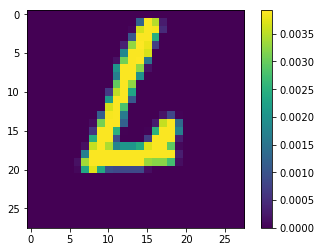

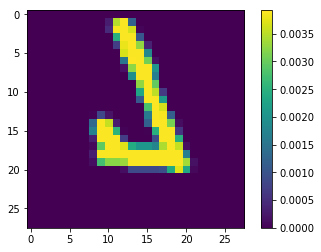

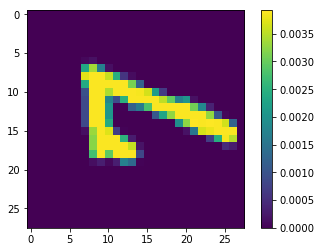

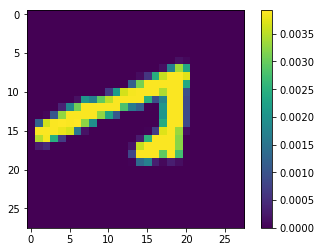

In [136]:
plt.figure()
plt.imshow(samples_x[0])
plt.colorbar()
plt.grid(False)

plt.figure()
plt.imshow(samples_x[1])
plt.colorbar()
plt.grid(False)

plt.figure()
plt.imshow(samples_x[2])
plt.colorbar()
plt.grid(False)

plt.figure()
plt.imshow(samples_x[3])
plt.colorbar()
plt.grid(False)


plt.show()

In [137]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": samples_x},
    shuffle=False)

In [138]:
predictions = mnist_classifier.predict(input_fn = pred_input_fn)

In [139]:
def decode(c):
    # too lazy to implement it properly
    vector =[]
    for i in range(80):
        if i == c:
            vector.append(1)
        else:
            vector.append(0)
    for label in range(10):
        for angle in range(8):
            if str_to_vect(label, angle) == vector:
                if angle in range(4):
                    out = str(90 * (4-angle)) + ' degrees'
                elif angle == 4:
                    out = 'FLIP_TOP_BOTTOM'
                elif angle == 5:
                    out = '90 degree then FLIP_LEFT_RIGHT'
                elif angle == 6:
                    out = 'FLIP_LEFT_RIGHT'
                elif angle == 7:
                    out = '90 degree then FLIP_TOP_BOTTOM'
                else:
                    out = 'errorrr'
                return label, out

# operations[g_f_i[0]] = (lambda x: tf.image.rot90(x, k =0))
# operations[g_f_i[1]] = (lambda x: tf.image.rot90(x, k =3))
# operations[g_f_i[2]] = (lambda x: tf.image.rot90(x, k =2))
# operations[g_f_i[3]] = (lambda x: tf.image.rot90(x, k =1))

# if len(G) > 4:
#     operations[g_f_i[4]] = (lambda x: tf.image.flip_up_down(x))
#     operations[g_f_i[5]] = (lambda x: tf.image.flip_left_right(tf.image.rot90(x, k = 1)))
#     operations[g_f_i[6]] = (lambda x: tf.image.flip_left_right(x))
#     operations[g_f_i[7]] = (lambda x: tf.image.flip_up_down(tf.image.rot90(x, k = 1)))

In [140]:
print(decode(73))

(3, '90 degree then FLIP_TOP_BOTTOM')


In [141]:
for prediction in predictions:
    print (decode(prediction['classes']), '\n', prediction['probabilities'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/s0/_bjfgcs11910zcp53lw2y3pc0000gn/T/tmpe2m1jxv7/model.ckpt-255
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
(7, '180 degrees') 
 [3.5840116e-04 4.5932717e-05 1.4755561e-03 7.0483616e-04 2.7231371e-03
 3.4159373e-03 1.2117551e-02 1.2180382e-01 6.6421814e-03 1.9164879e-02
 8.8286151e-06 2.5232220e-08 1.0914830e-06 3.3321890e-09 1.6296306e-03
 8.9439226e-07 1.9905556e-04 1.4868908e-04 1.6945032e-07 1.7112009e-04
 4.2877436e-04 7.2647876e-05 1.0275522e-03 1.0814457e-03 3.3896049e-03
 5.0358973e-03 7.4678790e-03 3.1097186e-01 1.0520889e-02 3.4047462e-02
 9.1135753e-06 1.8917497e-08 8.0178160e-07 2.5942799e-09 1.5279741e-03
 8.0063927e-07 1.6287807e-04 1.6002955e-04 1.4864759e-07 1.6253175e-04
 2.8612680e-04 5.8123671e-05 8.9027779e-04 8.1858394e-04 2.9691355e-03
 3.6934437e-03 6.3195899e-03 

In [122]:
samples_y.shape

(8, 80)

In [123]:
for y in samples_y:
    print (y.argmax(), decode(y.argmax()))

27 (7, '180 degrees')
47 (7, 'FLIP_TOP_BOTTOM')
37 (7, '90 degrees')
57 (7, '90 degree then FLIP_LEFT_RIGHT')
7 (7, '360 degrees')
67 (7, 'FLIP_LEFT_RIGHT')
17 (7, '270 degrees')
77 (7, '90 degree then FLIP_TOP_BOTTOM')
